In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import os

# Data preparation

In [2]:
path = "data/"

In [3]:
states = ["idle", "running", "stairs", "walking"]

df = pd.DataFrame(columns=[
    'state',
    'x_mean', 'x_max', 'x_min', 'x_std', 'x_var', 'x_median', 'x_range', 'x_rms',
    'y_mean', 'y_max', 'y_min', 'y_std', 'y_var', 'y_median', 'y_range', 'y_rms',
    'z_mean', 'z_max', 'z_min', 'z_std', 'z_var', 'z_median', 'z_range', 'z_rms'
])

def compute_features(column):
    features = {
        'mean': column.mean(),
        'max': column.max(),
        'min': column.min(),
        'std': column.std(),
        'var': column.var(),
        'median': column.median(),
        'range': column.max() - column.min(),
        'rms': np.sqrt(np.mean(column**2))
    }
    return features

In [4]:
for state in states:
  files_list = os.listdir(f"{path}{state}")
  for file_name in files_list:
    current_path = f"{path}{state}/{file_name}"
    data = pd.read_csv(current_path)
    x = data[data.columns[0]]
    y = data[data.columns[1]]
    z = data[data.columns[2]]

    x_features = compute_features(x)
    y_features = compute_features(y)
    z_features = compute_features(z)

    new_data = pd.DataFrame({
            'state': [state],
            'x_mean': [x_features['mean']], 'x_max': [x_features['max']], 'x_min': [x_features['min']], 'x_std': [x_features['std']],
            'x_var': [x_features['var']], 'x_median': [x_features['median']], 'x_range': [x_features['range']], 'x_rms': [x_features['rms']],
            'y_mean': [y_features['mean']], 'y_max': [y_features['max']], 'y_min': [y_features['min']], 'y_std': [y_features['std']],
            'y_var': [y_features['var']], 'y_median': [y_features['median']], 'y_range': [y_features['range']], 'y_rms': [y_features['rms']],
            'z_mean': [z_features['mean']], 'z_max': [z_features['max']], 'z_min': [z_features['min']], 'z_std': [z_features['std']],
            'z_var': [z_features['var']], 'z_median': [z_features['median']], 'z_range': [z_features['range']], 'z_rms': [z_features['rms']]
    })

    df = pd.concat([df, new_data], ignore_index = True)

/tmp/ipykernel_6425/513371256.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_data], ignore_index = True)


## Graphs of computed features

In [5]:
def graph(column):
  plt.plot(df["state"], df[column], ".")
  plt.grid(True)
  plt.xlabel("state")
  plt.ylabel(column)
  plt.show()

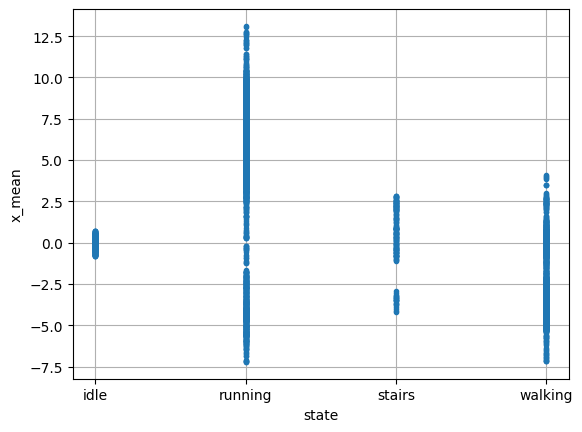

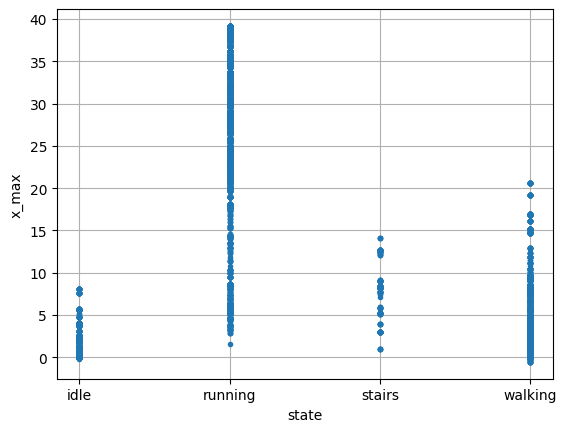

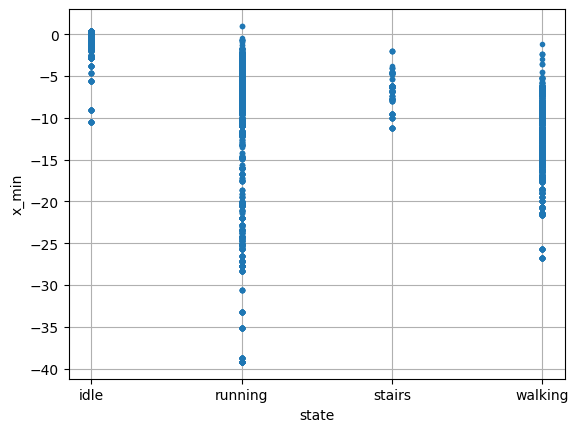

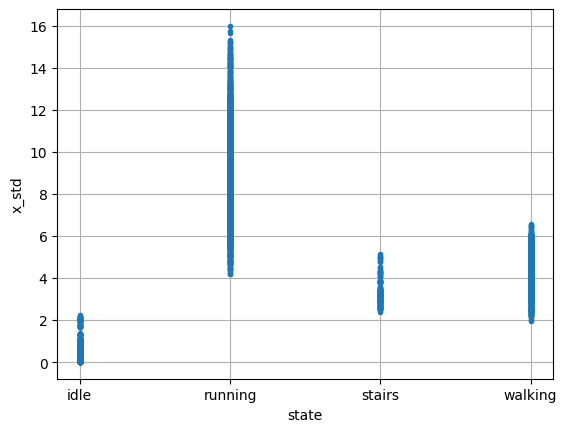

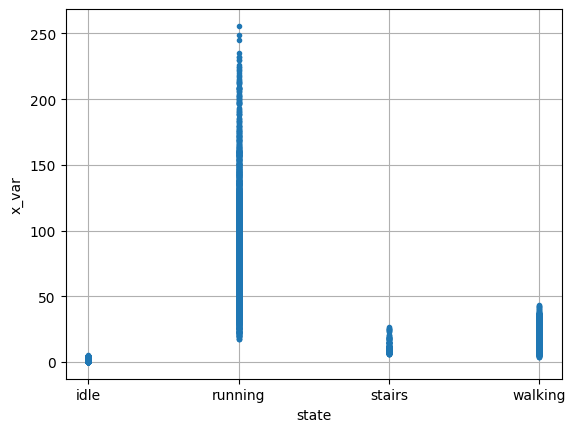

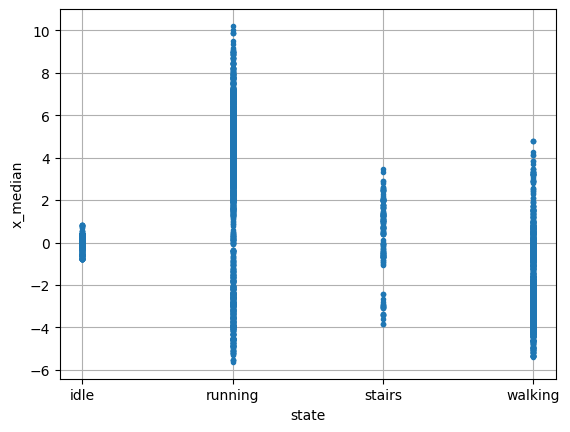

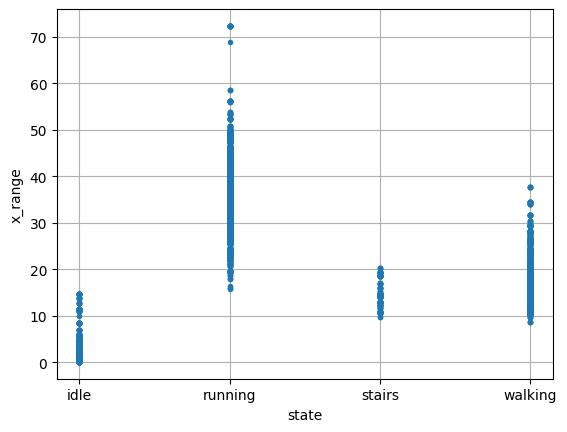

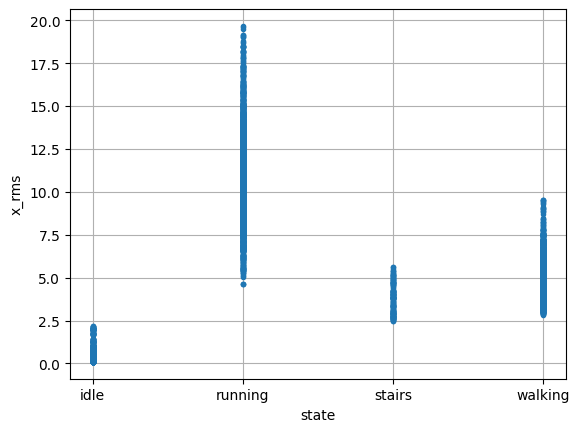

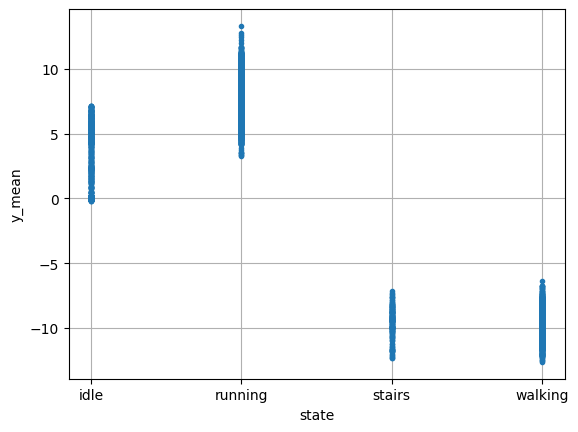

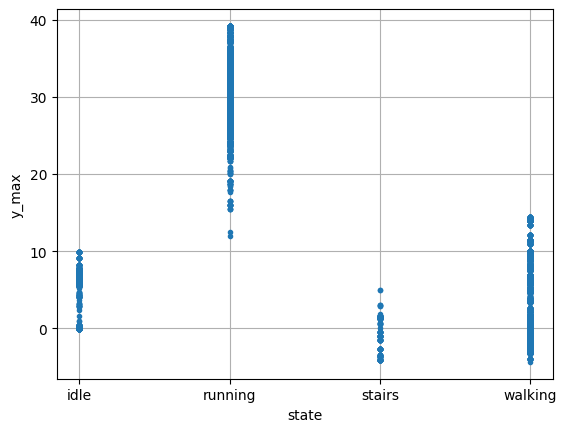

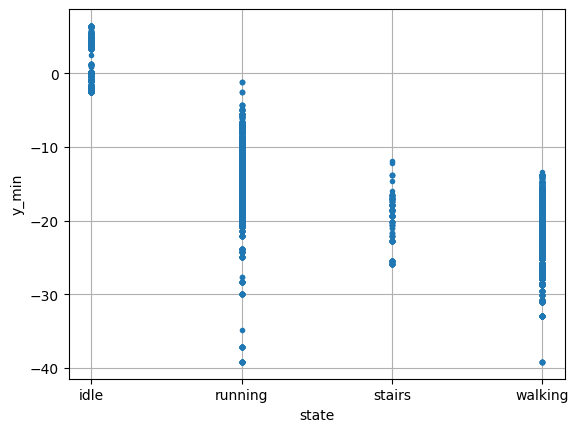

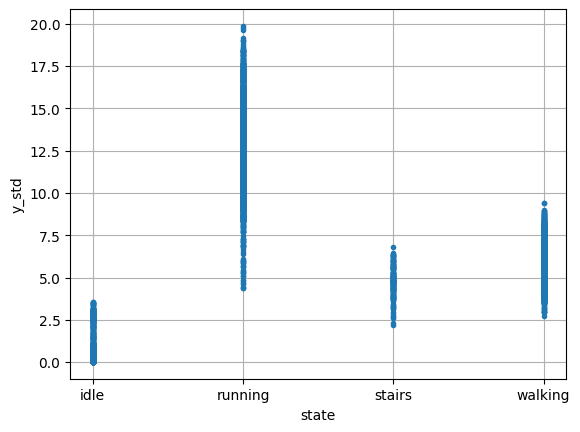

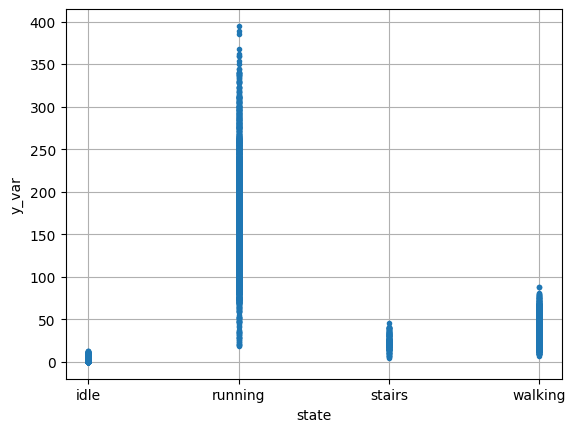

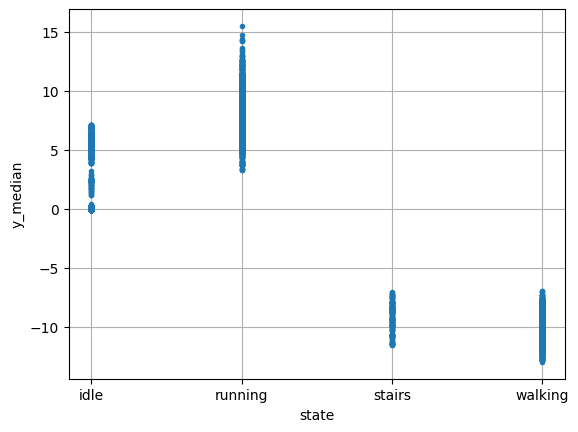

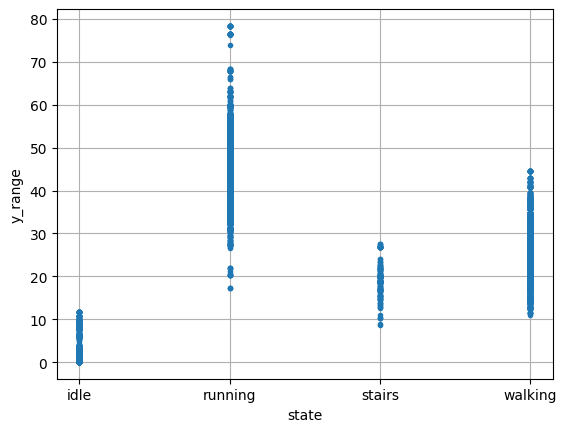

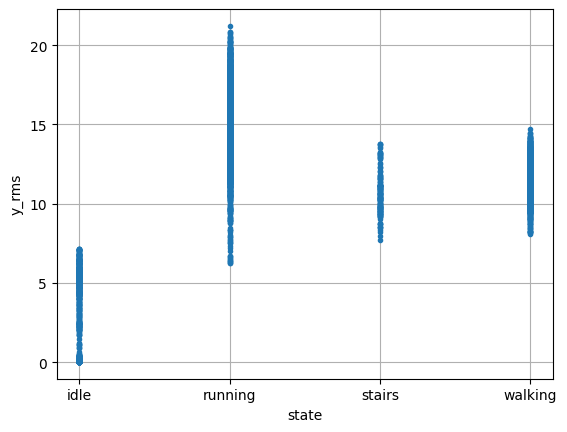

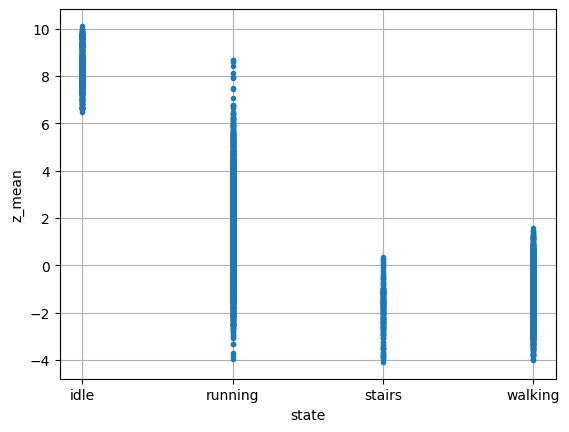

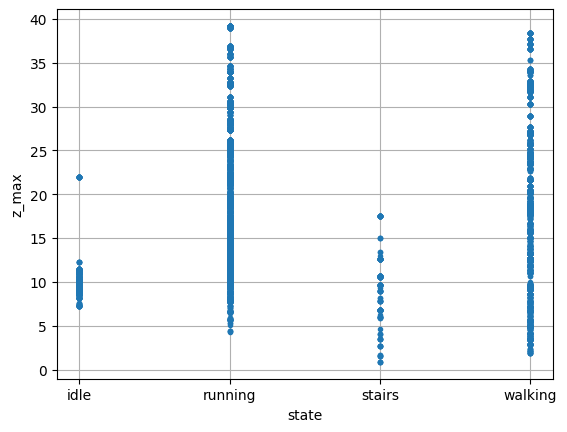

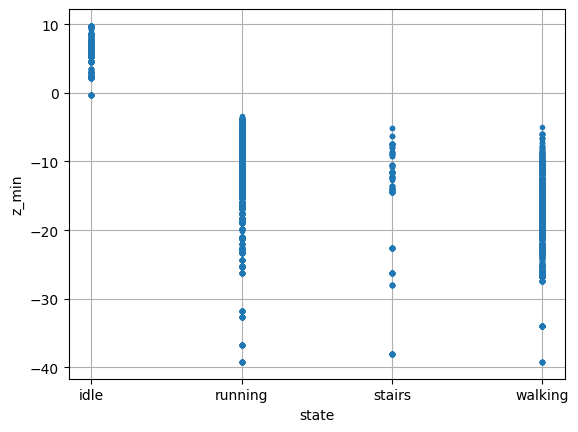

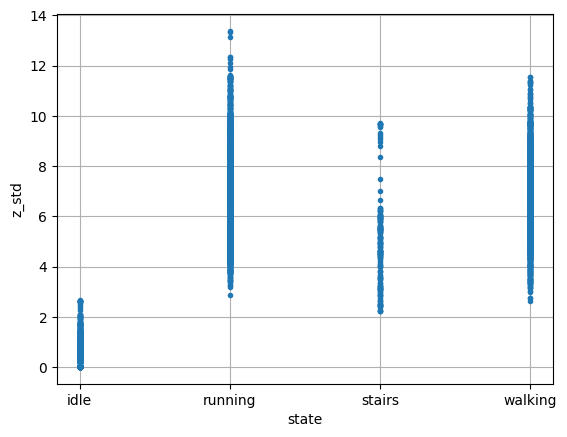

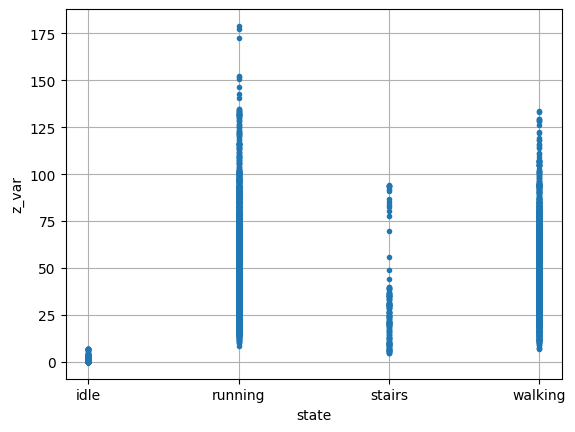

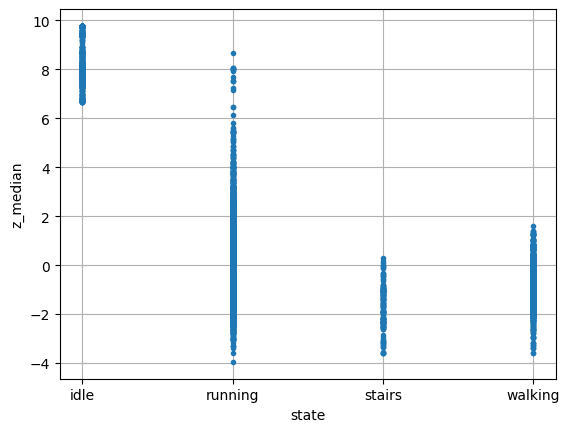

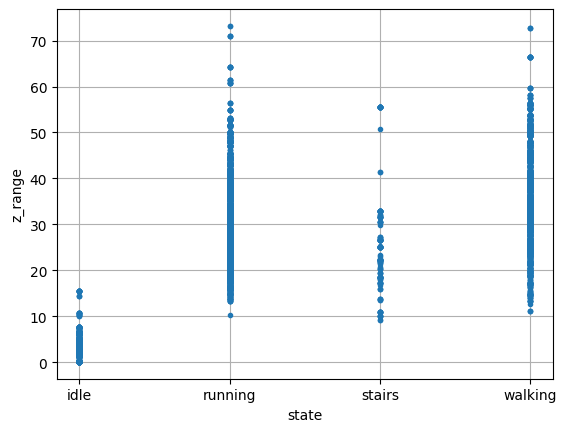

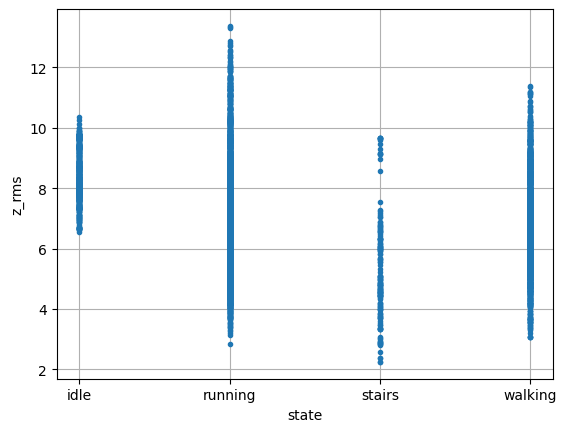

In [6]:
for column in df.columns[1:]:
  graph(column)

In [7]:
X = df[df.columns[1:]]
y = df["state"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=11)

In [8]:
def plot_results(X_train, y_train, X_test, y_test, y_pred, name):
    # Prepare train data
    train_data = pd.DataFrame(X_train, columns=df.columns[1:])
    train_data['state'] = y_train.values
    train_data['set'] = 'train'

    # Prepare test data
    test_data = pd.DataFrame(X_test, columns=df.columns[1:])
    test_data['state'] = y_test.values
    test_data['predicted_state'] = y_pred
    test_data['set'] = 'test'
    test_data['correct'] = test_data['state'] == test_data['predicted_state']

    test_data['correct'] = test_data['correct'].astype(bool)

    # Combine train and test data
    plot_data = pd.concat([train_data, test_data], ignore_index=True)

    # Plot the data
    plt.figure(figsize=(14, 10))
    sns.scatterplot(data=plot_data[plot_data['set'] == 'train'], x='x_mean', y='y_mean', color='blue', alpha=0.3, label='Train data')
    sns.scatterplot(data=plot_data[(plot_data['set'] == 'test') & (plot_data['correct'] == True)], x='x_mean', y='y_mean', color='green', label='Correct Test data')
    sns.scatterplot(data=plot_data[(plot_data['set'] == 'test') & (plot_data['correct'] == False)], x='x_mean', y='y_mean', color='red', label='Incorrect Test data')

    plt.title(name)
    plt.xlabel('x_mean')
    plt.ylabel('y_mean')
    plt.legend()
    plt.show()
    return test_data

# SVM model

In [9]:
svm_classifier = SVC(random_state=11)
svm_classifier.fit(X_train, y_train)

svm_y_pred = svm_classifier.predict(X_test)

## Visualization of model accuracy

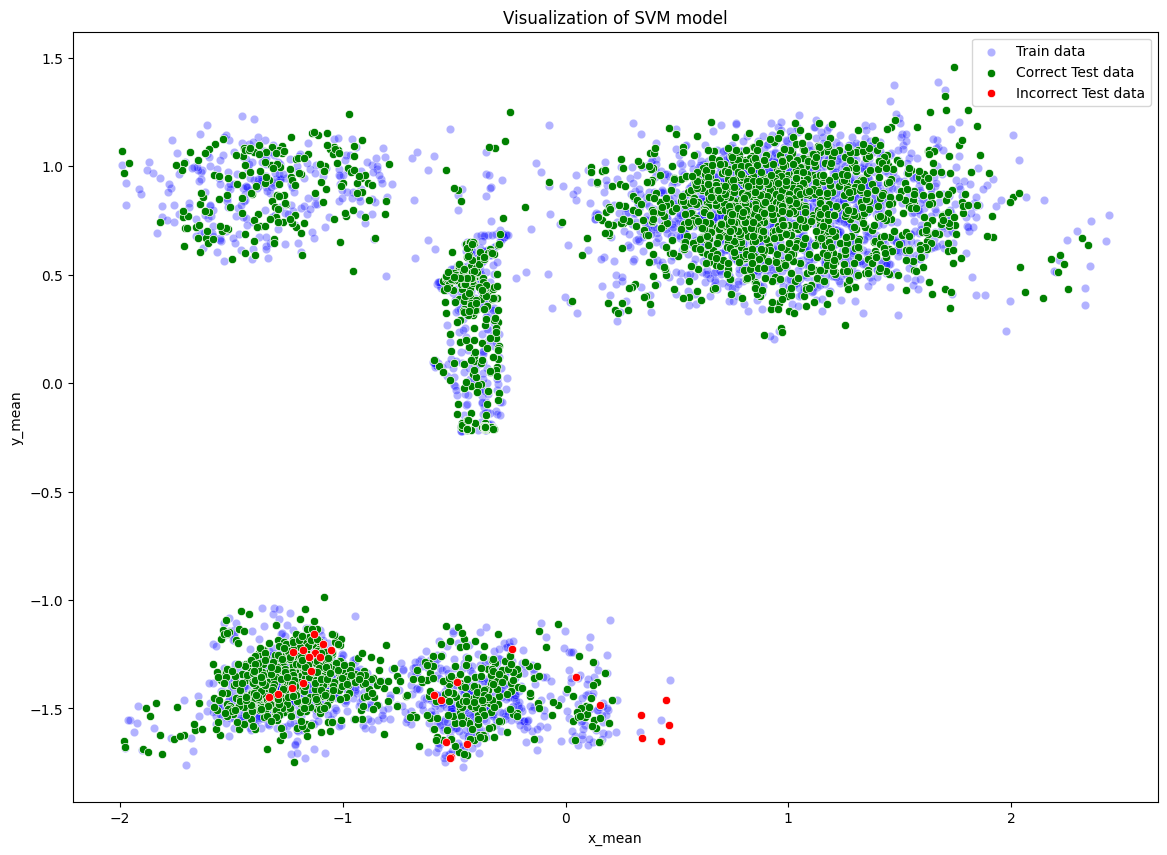

In [10]:
svm_test_data = plot_results(X_train,y_train,X_test,y_test, svm_y_pred, "Visualization of SVM model")

## Misclassifications

In [11]:
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"Accuracy: {svm_accuracy * 100:.2f}%")

svm_misclassifications = svm_test_data[svm_test_data['correct'] == False]
svm_misclass_counts = svm_misclassifications.groupby(['state', 'predicted_state']).size().reset_index(name='count')

print("Misclassifications:")
for index, row in svm_misclass_counts.iterrows():
    print(f"{row['state']} - {row['count']} classificated as {row['predicted_state']}")

Accuracy: 98.92%
Misclassifications:
stairs - 21 classificated as walking
walking - 7 classificated as stairs


## Summary

In summary, the trained model achieved an accuracy of 98.92% and made 28 mistakes. The states that were confused were "stairs" and "walking" both ways, but "stairs" was more often incorrectly interpreted as "walking" than the other way around.

# Decision tree Model

In [12]:
dt_classifier = DecisionTreeClassifier(random_state=11)
dt_classifier.fit(X_train, y_train)

dt_y_pred = dt_classifier.predict(X_test)

## Decision tree

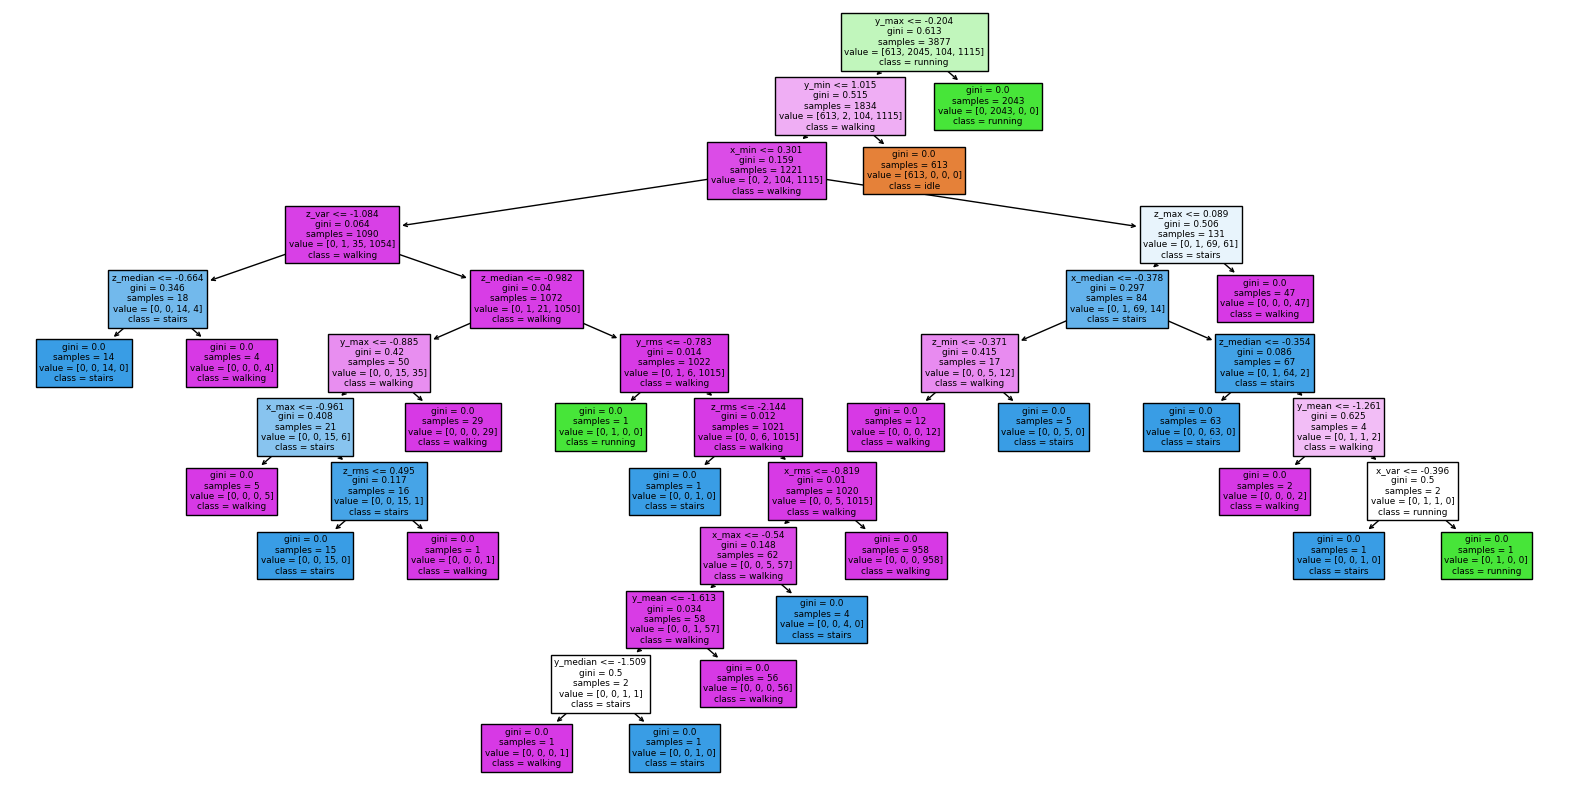

In [13]:
plt.figure(figsize=(20,10))
plot_tree(dt_classifier, filled=True, feature_names=X.columns, class_names=['idle', 'running', 'stairs', 'walking'])
plt.show()

## Visualization of model accuracy

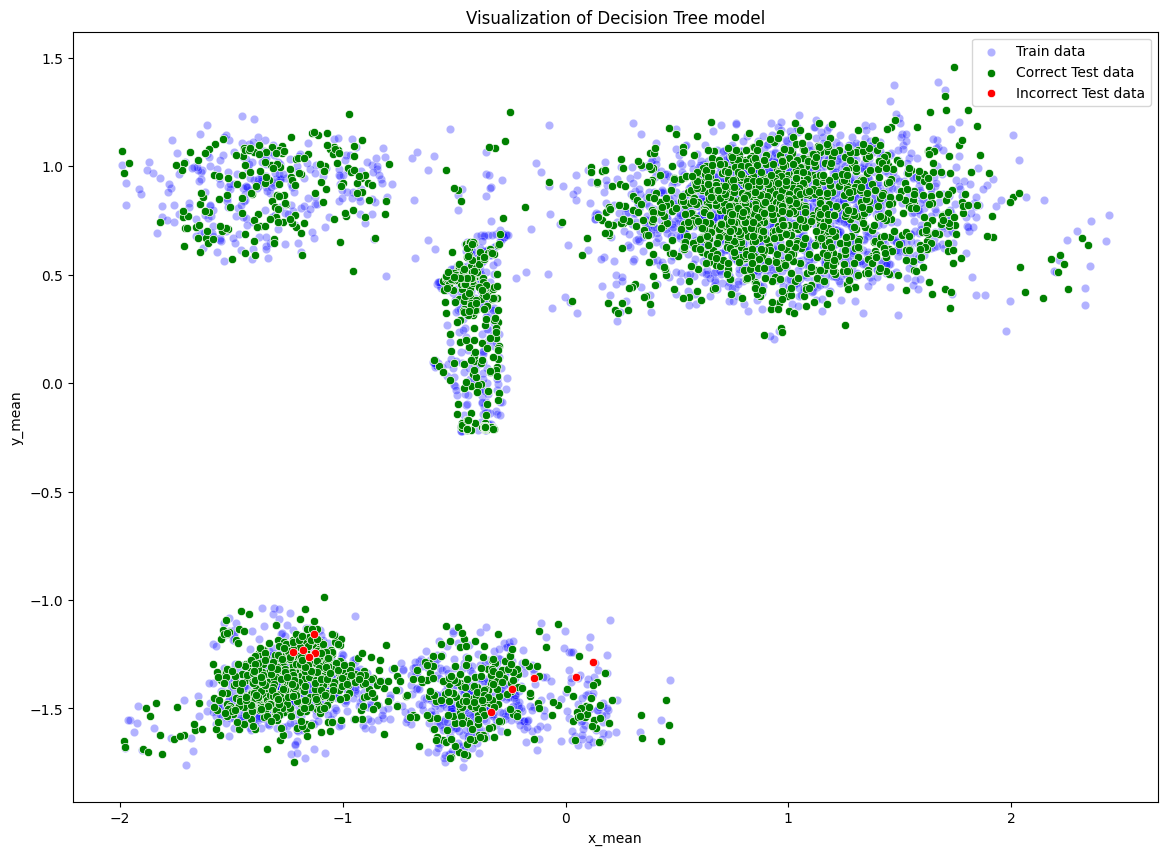

In [14]:
dt_test_data = plot_results(X_train,y_train,X_test,y_test, dt_y_pred, "Visualization of Decision Tree model")

## Misclassifications

In [15]:
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print(f"Accuracy: {dt_accuracy * 100:.2f}%")

dt_misclassifications = dt_test_data[dt_test_data['correct'] == False]
dt_misclass_counts = dt_misclassifications.groupby(['state', 'predicted_state']).size().reset_index(name='count')

print("Misclassifications:")
for index, row in dt_misclass_counts.iterrows():
    print(f"{row['state']} - {row['count']} classificated as {row['predicted_state']}")

Accuracy: 99.61%
Misclassifications:
stairs - 7 classificated as walking
walking - 3 classificated as stairs


## Summary

In summary, the trained model achieved an accuracy of 99.62% and made 10 mistakes. The states that were confused were "stairs" and "walking" both ways, but "stairs" was more often incorrectly interpreted as "walking" than the other way around.

# Conclusion

Comparing both models, the decision tree model demonstrated better effectiveness and also offers greater transparency in terms of how it operates. By constructing the tree, we can precisely track the basis on which the samples are split.